# Analysis of tuning curve modulation by optogenetic stimuli on top of drifting grating stimulus
- Different levels of opto depolarization strength ("opto_depol_pct")
- Different contrast levels ("contrast_levels")
- Sigmoidal curve fits to quantify modulation of tuning curves

Requirements:
- "single_cell_psths" launched with bbp-workflow
- PSTH data for PV, SOM, and PYR cells

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from bluepy import Cell, Synapse, Circuit, Simulation
import os
import pickle
import tqdm
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', message='invalid value encountered in double_scalars')
warnings.filterwarnings('ignore', message='Mean of empty slice')

In [2]:
sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/visual_contrast/70adfc43-8848-4d3a-8e1a-3042a1a5fd77/analyses/simulations.pkl' # Conuctance based, Ca1.05, param set 58, hex0_PV only, 100% sub-fraction, 0-100% opto intensities, full tuning curves
# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/visual_contrast/847083ee-2235-4226-b504-968be31414eb/analyses/simulations.pkl' # Conuctance based, Ca1.05, param set 58, hex0_SOM only, 100% sub-fraction, 0-100% opto intensities, full tuning curves

# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/visual_contrast/ce41c578-6158-4b46-adca-deaff4b2f5af/analyses/simulations.pkl' # Conuctance based, Ca1.05, param set 58, hex0_PV only, 50% sub-fraction, 0-100% opto intensities, full tuning curves
# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/visual_contrast/9d7ce11c-a705-48ce-a717-e0dfda70be11/analyses/simulations.pkl' # Conuctance based, Ca1.05, param set 58, hex0_SOM only, 50% sub-fraction, 0-100% opto intensities, full tuning curves

sims = pd.read_pickle(sims_file)
num_sims = len(sims)
circuit = Simulation(sims.iloc[0]).circuit

res_path = os.path.join(os.path.split(sims_file)[0], 'output')
save_path = os.path.join(os.path.split(sims_file)[0], 'visual_contrast_tuning_analysis')
if not os.path.exists(save_path):
    os.makedirs(save_path)

Have keys ({'desired_unconnected_fr_L23I', 'desired_unconnected_fr_L1I', 'desired_unconnected_fr_L6I', 'desired_unconnected_fr_L23E', 'depol_stdev_mean_ratio', 'desired_unconnected_fr_L5I', 'desired_connected_fr_L6E', 'desired_unconnected_fr_L5E', 'desired_connected_fr_L1I', 'desired_connected_fr_L6I', 'desired_unconnected_fr_L4E', 'desired_connected_proportion_of_invivo_frs', 'desired_connected_fr_L4I', 'desired_connected_fr_L23E', 'desired_connected_fr_L5E', 'desired_unconnected_fr_L4I', 'desired_unconnected_fr_L6E', 'desired_connected_fr_L5I', 'desired_connected_fr_L23I', 'desired_connected_fr_L4E'}) that are not defined for section: Run


### Load PSTH data

In [3]:
# Load PSTH results ("single_cell_psths" launched with bbp-workflow)
psth_res_name = 'single_cell_psths'
name_suffix = '__hex0'

psth_data_PYR = {}
psth_data_PV = {}
psth_data_SOM = {}
cond_names = sims.index.names
for sim_idx, (cond, cfg_path) in enumerate(sims.iteritems()):
    cond_dict = dict(zip(cond_names, cond))
    sim_id = os.path.split(os.path.split(cfg_path)[0])[-1] # Subfolder name (i.e., 000, 001, ...)
    sim_spec = '__'.join([f'{k}_{v}' for k, v in cond_dict.items()]) # Sim conditions (e.g., sparsity_1.0__rate_bk_0.2__rate_max_10.0)

    res_file = os.path.join(res_path, psth_res_name, f'{psth_res_name}{name_suffix}_PYR__SIM{sim_id}__{sim_spec}.pickle')
    assert os.path.exists(res_file), f'ERROR: "{res_file}" not found!'
    with open(res_file, 'rb') as f:
        res = pickle.load(f)
    psth_data_PYR[sim_idx] = res

    res_file = os.path.join(res_path, psth_res_name, f'{psth_res_name}{name_suffix}_PV__SIM{sim_id}__{sim_spec}.pickle')
    assert os.path.exists(res_file), f'ERROR: "{res_file}" not found!'
    with open(res_file, 'rb') as f:
        res = pickle.load(f)
    psth_data_PV[sim_idx] = res

    res_file = os.path.join(res_path, psth_res_name, f'{psth_res_name}{name_suffix}_SOM__SIM{sim_id}__{sim_spec}.pickle')
    assert os.path.exists(res_file), f'ERROR: "{res_file}" not found!'
    with open(res_file, 'rb') as f:
        res = pickle.load(f)
    psth_data_SOM[sim_idx] = res

tuning_property = sims.index.names[np.where(np.array(sims.index.levshape) > 1)[0][0]]
print(f'Tuning property: {tuning_property}')

Tuning property: opto_depol_pct


In [4]:
# Get opto depolarization & contrast levels
opto_depol_pct = None
contrasts = None
for psth_data in [psth_data_PYR, psth_data_PV, psth_data_SOM]:
    pct_tmp = [psth_data[sidx]['opto_cfg']['cfg']['opto_depol_pct'] for sidx in range(len(psth_data))]
    ctr_tmp = psth_data[0]['stim_cfg']['cfg']['contrast_levels']
    if opto_depol_pct is None:
        opto_depol_pct = pct_tmp
    else:
        assert np.array_equal(opto_depol_pct, pct_tmp), 'ERROR: "opto_depol_pct" not consistent!'
    if contrasts is None:
        contrasts = ctr_tmp
    else:
        assert np.array_equal(contrasts, ctr_tmp), 'ERROR: "contrast_levels" not consistent!'
print(f'opto_depol_pct = {opto_depol_pct}')
print(f'contrasts = {contrasts}')

opto_depol_pct = [0.0, 20.0, 40.0, 60.0, 80.0, 100.0]
contrasts = [0.06, 0.12, 0.24, 0.5, 1.0]


### Compute normalized tuning curves

In [5]:
# Compute tuning curves
def compute_tuning(psth_data, resp_int, base_int, do_norm=False, norm_contrast=None, norm_opto=None, norm_once=None):
    """Computes single-cell tuning with or without normalization"""

    sim_ids = list(psth_data.keys())
    contrasts = None # Contrast levels
    tuning_curves = [] # Normalized tuning curves
    baselines = [] # Normalized baseline activities
    gids = []
    norm_rates = []
    print('PROCESSING tuning curves...', end='')
    for sim_idx in sim_ids:
        print(f' {sim_idx}', end='')

        if contrasts is None:
            contrasts = psth_data[sim_idx]['stim_cfg']['cfg']['contrast_levels']
        else:
            assert np.all(np.array(contrasts) == psth_data[sim_idx]['stim_cfg']['cfg']['contrast_levels'])

        t_rate = psth_data[sim_idx]['t_rate']
        num_patterns = int(len(psth_data[sim_idx]['rates']) / 2)
        patt_ind = list(range(num_patterns)) # Indices for raw contrast patterns
        opto_ind = list(range(num_patterns, 2 * num_patterns)) # Indices for contrast patterns with opto stim
        if do_norm:
            assert norm_contrast in contrasts, 'ERROR: Normalisation contrast level not found!'
            norm_idx = np.where(np.array(contrasts) == norm_contrast)[0][0]
            if norm_opto:
                norm_idx = norm_idx + len(contrasts) # Pattern with opto stim

        if len(gids) == 0:
            gids = psth_data[sim_idx]['gids']
            num_cells = len(gids)
        else:
            assert np.array_equal(gids, psth_data[sim_idx]['gids']), 'ERROR: GIDs mismatch across simulations!'
        avg_responses = []
        avg_baseline = []
        norm_responses = [] # Normalized rates based on max. rate at given norm_contrast level (w/o opto!)
        norm_baseline = [] # Normalized baseline rates based on max. rate at given norm_contrast level (w/o opto!)
        for gidx, gid in enumerate(gids):
            resp_rates = []
            base_rates = []
            for p in range(2 * num_patterns):
                spike_trains = psth_data[sim_idx]['spike_trains'][p][gid]
                resp_rates.append([1e3 * np.sum(np.logical_and(np.array(st) >= resp_int[0], np.array(st) < resp_int[-1])) / np.diff(resp_int)[0] for st in spike_trains])
                base_rates.append([1e3 * np.sum(np.logical_and(np.array(st) >= base_int[0], np.array(st) < base_int[-1])) / np.diff(base_int)[0] for st in spike_trains])
            avg_responses.append(resp_rates)
            avg_baseline.append(base_rates)
            if do_norm:
                norm_rate = np.mean(resp_rates[norm_idx]) # Maximum rate used for normalization
                if norm_once:
                    if len(norm_rates) == len(gids):
                        norm_rate = norm_rates[gidx]
                    else:
                        norm_rates.append(norm_rate)
            else:
                norm_rate = 1.0 # No normalization
            norm_responses.append([[r / norm_rate if norm_rate > 0.0 else np.nan for r in resp_rates[p]] for p in range(2 * num_patterns)])
            norm_baseline.append([[r / norm_rate if norm_rate > 0.0 else np.nan for r in base_rates[p]] for p in range(2 * num_patterns)])

        def resp_stat(responses, fct):
            """Computes statistics given by fct over response trials"""
            return np.array([[fct(r) if len(r) > 0 else np.nan for r in rr] for rr in responses])

        contr_resp_func = {}
        contr_resp_func.update({'mean': resp_stat(norm_responses, np.mean)})
        contr_resp_func.update({'std': resp_stat(norm_responses, np.std)})
        contr_resp_func.update({'N': resp_stat(norm_responses, len)})
        contr_resp_func.update({'sem': contr_resp_func['std'] / np.sqrt(contr_resp_func['N'])})

        baseline_activity = {}
        baseline_activity.update({'mean': resp_stat(norm_baseline, np.mean)})
        baseline_activity.update({'std': resp_stat(norm_baseline, np.std)})
        baseline_activity.update({'N': resp_stat(norm_baseline, len)})
        baseline_activity.update({'sem': baseline_activity['std'] / np.sqrt(baseline_activity['N'])})

        tuning_curves.append(contr_resp_func)
        baselines.append(baseline_activity)

    return tuning_curves, baselines, gids

In [6]:
# Compute normalized PYR tuning...
# norm_tuning_curves_PYR, norm_baselines_PYR, gids_PYR = compute_tuning(psth_data_PYR, resp_int=[0, 1000], base_int=[1000, 2000], do_norm=True, norm_contrast=1.0, norm_opto=True, norm_once=True)
# np.savez(os.path.join(save_path, 'norm_tuning_curves_PYR.npz'), norm_tuning_curves_PYR=norm_tuning_curves_PYR, norm_baselines_PYR=norm_baselines_PYR, gids_PYR=gids_PYR)

# ...OR load from file
tuning_data = np.load(os.path.join(save_path, 'norm_tuning_curves_PYR.npz'), allow_pickle=True)
norm_tuning_curves_PYR = list(tuning_data['norm_tuning_curves_PYR'])
norm_baselines_PYR = list(tuning_data['norm_baselines_PYR'])
gids_PYR = tuning_data['gids_PYR']
del tuning_data

In [7]:
# Compute normalized PV tuning...
# norm_tuning_curves_PV, norm_baselines_PV, gids_PV = compute_tuning(psth_data_PV, resp_int=[0, 1000], base_int=[1000, 2000], do_norm=True, norm_contrast=1.0, norm_opto=True, norm_once=True)
# np.savez(os.path.join(save_path, 'norm_tuning_curves_PV.npz'), norm_tuning_curves_PV=norm_tuning_curves_PV, norm_baselines_PV=norm_baselines_PV, gids_PV=gids_PV)

# ...OR load from file
tuning_data = np.load(os.path.join(save_path, 'norm_tuning_curves_PV.npz'), allow_pickle=True)
norm_tuning_curves_PV = list(tuning_data['norm_tuning_curves_PV'])
norm_baselines_PV = list(tuning_data['norm_baselines_PV'])
gids_PV = tuning_data['gids_PV']
del tuning_data

In [8]:
# Compute normalized SOM tuning...
# norm_tuning_curves_SOM, norm_baselines_SOM, gids_SOM = compute_tuning(psth_data_SOM, resp_int=[0, 1000], base_int=[1000, 2000], do_norm=True, norm_contrast=1.0, norm_opto=True, norm_once=True)
# np.savez(os.path.join(save_path, 'norm_tuning_curves_SOM.npz'), norm_tuning_curves_SOM=norm_tuning_curves_SOM, norm_baselines_SOM=norm_baselines_SOM, gids_SOM=gids_SOM)

# ...OR load from file
tuning_data = np.load(os.path.join(save_path, 'norm_tuning_curves_SOM.npz'), allow_pickle=True)
norm_tuning_curves_SOM = list(tuning_data['norm_tuning_curves_SOM'])
norm_baselines_SOM = list(tuning_data['norm_baselines_SOM'])
gids_SOM = tuning_data['gids_SOM']
del tuning_data

In [9]:
def plot_mean_modulated_contrast_response_function_per_layer(tuning_curves, baselines, gids, circuit, contrasts, tuning_values, merged_layers=None, save_path=None, save_spec=None, num_y_zoom=None, tuning_property=None, title_spec=None):
    """Plot contrast response functions (norm. contrast tuning curves) modulated by opto stim"""
    num_sims = len(tuning_values)
    num_patterns = len(contrasts)
    pidx = np.arange(num_patterns) + num_patterns # Pattern indices with opto stim (i.e., starting at <num_patterns>)

    layers = list(np.unique(circuit.cells.get(gids, properties='layer')))
    if merged_layers is not None:
        for mlay in merged_layers: # List of lists expeted
            layers = list(np.setdiff1d(layers, mlay)) # Remove single layers from list
            layers.append(mlay) # Add merged layers to list
            layers = sorted(layers, key=lambda x: x[0] if isinstance(x, list) else x) # Re-sort based on first of merged layers

    plt.figure(figsize=(12, 3))
    for lidx, layer in enumerate(layers):
        plt.subplot(1, len(layers), lidx + 1)
        gids_sel = gids[np.isin(circuit.cells.get(gids, properties='layer'), layer)]

        depol_colors = plt.cm.viridis(np.linspace(0, 1, num_sims))
        gid_idx = np.where(np.isin(gids, gids_sel))[0]
        gid_idx = gid_idx[~np.any(np.isnan(baselines[0]['mean'][gid_idx, :][:, pidx]), 1)] # Remove (non-responding) GIDs with invalid norm. tuning
        assert len(gid_idx) > 0, 'ERROR: No GIDs selected!'
        for sidx in range(num_sims):
            if tuning_property is not None and '_pct' in tuning_property:
                lbl = f'{tuning_values[sidx]}%'
            else:
                lbl = f'{tuning_values[sidx]}'
            if tuning_values[sidx] == 0.0:
                plt.errorbar(range(num_patterns + 1), np.hstack((np.mean(baselines[sidx]['mean'][gid_idx, :][:, pidx]), np.mean(tuning_curves[sidx]['mean'][gid_idx, :][:, pidx], 0))), yerr=np.hstack((np.mean(baselines[sidx]['sem'][gid_idx, :][:, pidx]), np.mean(tuning_curves[sidx]['sem'][gid_idx, :][:, pidx], 0))), color=depol_colors[sidx, :], label=lbl)
            else:
                plt.errorbar(range(1, num_patterns + 1), np.mean(tuning_curves[sidx]['mean'][gid_idx, :][:, pidx], 0), yerr=np.mean(tuning_curves[sidx]['sem'][gid_idx, :][:, pidx], 0), color=depol_colors[sidx, :], label=lbl)
        plt.xlim((-0.25, num_patterns + 0.25))
        if num_y_zoom is not None:
            pidx_sel = np.arange(num_y_zoom) + num_patterns
            zoomed_data_min = [np.mean(tuning_curves[sidx]['mean'][gid_idx, :][:, pidx_sel], 0) - np.mean(tuning_curves[sidx]['sem'][gid_idx, :][:, pidx_sel], 0) for sidx in range(num_sims)]
            zoomed_data_max = [np.mean(tuning_curves[sidx]['mean'][gid_idx, :][:, pidx_sel], 0) + np.mean(tuning_curves[sidx]['sem'][gid_idx, :][:, pidx_sel], 0) for sidx in range(num_sims)]
            plt.ylim([np.min(zoomed_data_min), np.max(zoomed_data_max)])
        plt.xticks(range(num_patterns + 1), labels=[0.0] + contrasts)
        plt.xlabel('Contrast')
        plt.ylabel('Norm. rate')
        plt.grid()
#         plt.gca().spines['top'].set_visible(False)
#         plt.gca().spines['right'].set_visible(False)
        plt.title(f'L{"".join([str(lay) for lay in layer]) if isinstance(layer, list) else layer} (N={len(gid_idx)})')
    plt.legend(loc='center left', bbox_to_anchor=[1.0, 0.5], title=tuning_property)
    if isinstance(title_spec, str):
        title_spec = ' ' + title_spec
    else:
        title_spec = ''
    plt.suptitle('Contrast tuning' + title_spec, fontweight='bold')
    plt.tight_layout()
    if save_path is not None:
        if isinstance(save_spec, str):
            save_spec = '_' + save_spec
        else:
            save_spec = ''
        plt.savefig(os.path.join(save_path, f'mean_norm_contrast_tuning{save_spec}.png'), dpi=300)
    plt.show()


def plot_split_mean_modulated_contrast_response_function_per_layer(tuning_curves, baselines, gids, circuits, opto_props, contrasts, tuning_values, merged_layers=None, tuning_property=None, save_path=None, save_spec=None):
    """Plot contrast response functions (norm. contrast tuning curves) modulated by opto stim,
       splitted into cells that are (not) targeted by opto stimulus"""
    num_sims = len(tuning_values)
    assert len(circuits) == num_sims, f'ERROR: List of {num_sims} circuits required!'
    assert len(opto_props) == num_sims, f'ERROR: List of {num_sims} opto property dicts required!'

    num_patterns = len(contrasts)
    pidx = np.arange(num_patterns) + num_patterns # Pattern indices with opto stim (i.e., starting at <num_patterns>)

    layers = list(np.unique(circuits[0].cells.get(gids, properties='layer')))
    if merged_layers is not None:
        for mlay in merged_layers: # List of lists expeted
            layers = list(np.setdiff1d(layers, mlay)) # Remove single layers from list
            layers.append(mlay) # Add merged layers to list
            layers = sorted(layers, key=lambda x: x[0] if isinstance(x, list) else x) # Re-sort based on first of merged layers

    level_colors = plt.cm.viridis(np.linspace(0, 1, num_sims))
    tgt_ls = ['--', '-'] # Line styles for non-targeted/targeted cells

    plt.figure(figsize=(12, 3))
    print(f'Plotting ({num_sims} steps)...', end='')
    for sidx in range(num_sims):
        print(f'{sidx + 1}', end=' ')
        # Select targeted/non-targeted GIDs
        tgt_gids = []
        for tgt in opto_props[sidx]['inject_target_names']:
            tgt_gids.append(circuits[sidx].cells.ids(tgt))
        if len(tgt_gids) > 0:
            tgt_gids = np.unique(np.hstack(tgt_gids))

        for lidx, layer in enumerate(layers):
            plt.subplot(1, len(layers), lidx + 1)
            gids_lay_sel = gids[np.isin(circuit.cells.get(gids, properties='layer'), layer)]
            gids_sel_tgt = np.intersect1d(gids_lay_sel, tgt_gids)
            gids_sel_nontgt = np.setdiff1d(gids_lay_sel, gids_sel_tgt)

            for sel_idx, gids_sel in enumerate([gids_sel_nontgt, gids_sel_tgt]):
                gid_idx = np.where(np.isin(gids, gids_sel))[0]
                gid_idx = gid_idx[~np.any(np.isnan(baselines[0]['mean'][gid_idx, :][:, pidx]), 1)] # Remove (non-responding) GIDs with invalid norm. tuning
                if len(gid_idx) == 0:
                    continue

                if sel_idx == 0:
                    lbl = f'{tuning_values[sidx]} (non-tgt)'
                else:
                    lbl = f'{tuning_values[sidx]} (tgt)'
                if tuning_values[sidx] == 0.0:
                    plt.errorbar(range(num_patterns + 1), np.hstack((np.mean(baselines[sidx]['mean'][gid_idx, :][:, pidx]), np.mean(tuning_curves[sidx]['mean'][gid_idx, :][:, pidx], 0))), yerr=np.hstack((np.mean(baselines[sidx]['sem'][gid_idx, :][:, pidx]), np.mean(tuning_curves[sidx]['sem'][gid_idx, :][:, pidx], 0))), color=level_colors[sidx, :], ls=tgt_ls[sel_idx], label=lbl)
                else:
                    plt.errorbar(range(1, num_patterns + 1), np.mean(tuning_curves[sidx]['mean'][gid_idx, :][:, pidx], 0), yerr=np.mean(tuning_curves[sidx]['sem'][gid_idx, :][:, pidx], 0), color=level_colors[sidx, :], ls=tgt_ls[sel_idx], label=lbl)
            plt.xlim((-0.25, num_patterns + 0.25))
            plt.xticks(range(num_patterns + 1), labels=[0.0] + contrasts)
            plt.xlabel('Contrast')
            plt.ylabel('Norm. rate')
            plt.grid()
            plt.title(f'L{"".join([str(lay) for lay in layer]) if isinstance(layer, list) else layer}')

    plt.legend(loc='center left', bbox_to_anchor=[1.0, 0.5], ncol=2, title=tuning_property)
    if isinstance(save_spec, str):
        title_spec = f' ({save_spec})'
    else:
        title_spec = ''
    plt.suptitle('Contrast tuning, modulated by opto stim' + title_spec, fontweight='bold')
    plt.tight_layout()
    if save_path is not None:
        if isinstance(save_spec, str):
            save_spec = '_' + save_spec
        else:
            save_spec = ''
        plt.savefig(os.path.join(save_path, f'split_mean_norm_contrast_tuning{save_spec}.png'), dpi=300)
    plt.show()

Target 'hex0_L1_PV' resolves to empty GID list
Target 'hex1_L1_PV' resolves to empty GID list
Target 'hex2_L1_PV' resolves to empty GID list
Target 'hex3_L1_PV' resolves to empty GID list
Target 'hex4_L1_PV' resolves to empty GID list
Target 'hex5_L1_PV' resolves to empty GID list
Target 'hex6_L1_PV' resolves to empty GID list
Target 'hex0_L1_SOM' resolves to empty GID list
Target 'hex1_L1_SOM' resolves to empty GID list
Target 'hex2_L1_SOM' resolves to empty GID list
Target 'hex3_L1_SOM' resolves to empty GID list
Target 'hex4_L1_SOM' resolves to empty GID list
Target 'hex5_L1_SOM' resolves to empty GID list
Target 'hex6_L1_SOM' resolves to empty GID list
Target 'hex0_L1_PYR' resolves to empty GID list
Target 'hex1_L1_PYR' resolves to empty GID list
Target 'hex2_L1_PYR' resolves to empty GID list
Target 'hex3_L1_PYR' resolves to empty GID list
Target 'hex4_L1_PYR' resolves to empty GID list
Target 'hex5_L1_PYR' resolves to empty GID list
Target 'hex6_L1_PYR' resolves to empty GID list

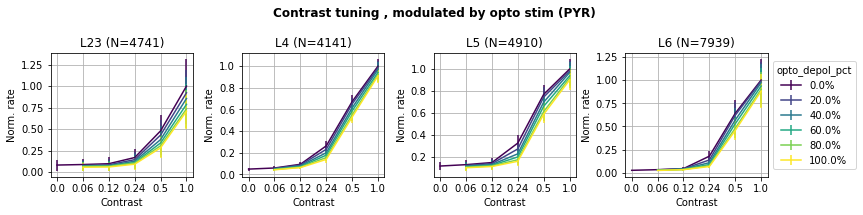

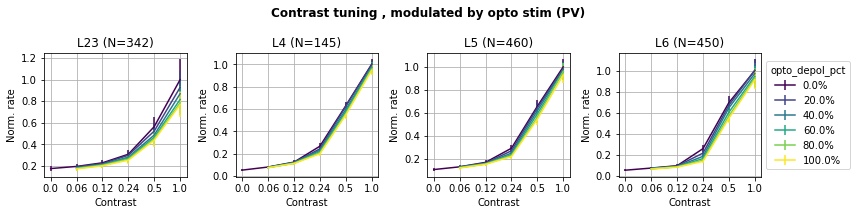

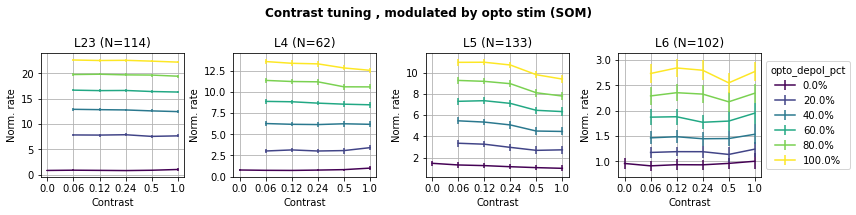

In [10]:
# Plot mean contrast tuning per layer, modulated by opto stim
for tc, bl, gids, lbl in zip([norm_tuning_curves_PYR, norm_tuning_curves_PV, norm_tuning_curves_SOM], [norm_baselines_PYR, norm_baselines_PV, norm_baselines_SOM], [gids_PYR, gids_PV, gids_SOM], ['PYR', 'PV', 'SOM']):
    plot_mean_modulated_contrast_response_function_per_layer(tc, bl, gids, circuit, contrasts, opto_depol_pct, merged_layers=[[2, 3]], save_path=save_path, save_spec=lbl, tuning_property=tuning_property, title_spec=f', modulated by opto stim ({lbl})')
    # plot_split_mean_modulated_contrast_response_function_per_layer(tc, bl, gids, circuit, contrasts, opto_depol_pct, merged_layers=[[2, 3]], save_path=save_path, save_spec=lbl, tuning_property=tuning_property, title_spec=f', modulated by opto stim ({lbl})')


### Check tuning behavior
- Mean norm. tuning (striclty) monotonously increasing?
- Mean norm. tuning above baseline?

In [290]:
def check_tuning_behavior(sims, gids, norm_tuning_curves, norm_baselines, contrasts):
    monot_inc = np.full((len(gids), len(sims)), False)
    strict_monot_inc = np.full((len(gids), len(sims)), False)
    above_baseline = np.full((len(gids), len(sims)), False)
    strict_above_baseline = np.full((len(gids), len(sims)), False)

    num_patterns = len(contrasts)
    pidx = np.arange(num_patterns) + num_patterns # Pattern indices with opto stim (i.e., starting at <num_patterns>)
    for sidx in range(len(norm_tuning_curves)):
        tc = norm_tuning_curves[sidx]['mean'][:, pidx]
        bl = np.mean(norm_baselines[sidx]['mean'][:, pidx], 1, keepdims=True)
        monot_inc[:, sidx] = np.all(np.diff(tc, axis=1) >= 0, axis=1)
        strict_monot_inc[:, sidx] = np.all(np.diff(tc, axis=1) > 0, axis=1)
        above_baseline[:, sidx] = np.all(tc >= bl, axis=1)
        strict_above_baseline[:, sidx] = np.all(tc > bl, axis=1)

    return monot_inc, strict_monot_inc, above_baseline, strict_above_baseline

In [293]:
# Check PYR/PV/SOM tuning behavior
monot_inc_PYR, strict_monot_inc_PYR, above_baseline_PYR, strict_above_baseline_PYR = check_tuning_behavior(sims, gids_PYR, norm_tuning_curves_PYR, norm_baselines_PYR, contrasts)
monot_inc_PV, strict_monot_inc_PV, above_baseline_PV, strict_above_baseline_PV = check_tuning_behavior(sims, gids_PV, norm_tuning_curves_PV, norm_baselines_PV, contrasts)
monot_inc_SOM, strict_monot_inc_SOM, above_baseline_SOM, strict_above_baseline_SOM = check_tuning_behavior(sims, gids_SOM, norm_tuning_curves_SOM, norm_baselines_SOM, contrasts)

### Extract effective opto intensities

In [222]:
def get_effective_opto_intensities(sims, gids, psth_data):
    opto_strength_eff = np.full((len(gids), len(sims)), np.nan)
    for sidx in range(len(sims)):
        c = Circuit(sims.iloc[sidx])
        opto_tgt = psth_data[sidx]['opto_cfg']['props']['inject_target_names']
        opto_eff = psth_data[sidx]['opto_cfg']['props']['inject_strengths'] # Effective strength
        # Run through all opto targets
        for tgt, eff in zip(opto_tgt, opto_eff):
            opto_gids = c.cells.ids(tgt)
            # Run through GIDs and set effective value, if part of opto target GIDs
            for gidx, gid in enumerate(gids):
                if gid in opto_gids:
                    assert np.isnan(opto_strength_eff[gidx, sidx]), f'ERROR: Effective opto target strength already set (gid={gid}, gidx={gidx}, sidx={sidx})!'
                    opto_strength_eff[gidx, sidx] = eff

    return opto_strength_eff

In [224]:
# Extract effective PYR opto stim strengths...
# opto_strength_eff_PYR = get_effective_opto_intensities(sims, gids_PYR, psth_data_PYR)
# np.savez(os.path.join(save_path, 'opto_strength_eff_PYR.npz'), opto_strength_eff_PYR=opto_strength_eff_PYR, opto_depol_pct=opto_depol_pct, gids_PYR=gids_PYR)

# ...OR load from file
opto_strength_data = np.load(os.path.join(save_path, 'opto_strength_eff_PYR.npz'), allow_pickle=True)
opto_strength_eff_PYR = opto_strength_data['opto_strength_eff_PYR']
del opto_strength_data

In [227]:
# Extract effective PV opto stim strengths...
# opto_strength_eff_PV = get_effective_opto_intensities(sims, gids_PV, psth_data_PV)
# np.savez(os.path.join(save_path, 'opto_strength_eff_PV.npz'), opto_strength_eff_PV=opto_strength_eff_PV, opto_depol_pct=opto_depol_pct, gids_PV=gids_PV)

# ...OR load from file
opto_strength_data = np.load(os.path.join(save_path, 'opto_strength_eff_PV.npz'), allow_pickle=True)
opto_strength_eff_PV = opto_strength_data['opto_strength_eff_PV']
del opto_strength_data

In [231]:
# Extract effective SOM opto stim strengths...
# opto_strength_eff_SOM = get_effective_opto_intensities(sims, gids_SOM, psth_data_SOM)
# np.savez(os.path.join(save_path, 'opto_strength_eff_SOM.npz'), opto_strength_eff_SOM=opto_strength_eff_SOM, opto_depol_pct=opto_depol_pct, gids_SOM=gids_SOM)

# ...OR load from file
opto_strength_data = np.load(os.path.join(save_path, 'opto_strength_eff_SOM.npz'), allow_pickle=True)
opto_strength_eff_SOM = opto_strength_data['opto_strength_eff_SOM']
del opto_strength_data

### Sigmoidal fit to normalized tuning curves

In [10]:
# Sigmoidal function
R = lambda c, m, n, Rmax, c50: (Rmax * c**n) / (c**n + c50**n) + m # Sigmoidal response function R(c) [Shapiro et al. 2021]
num_fit_params = R.__code__.co_argcount - 1
fit_param_names = R.__code__.co_varnames[1:]
# R(c) ... Amplitude of the evoked response at contrast c
# m ...... Baseline response to minimum contrast
# n ...... Exponent that determines the steepness of the curve
# Rmax ... Maximum elevation in response above the baseline
# c50 .... Contrast that generates a response elevation of half Rmax

In [11]:
# Sigmoidal fit to normalized tuning curve [parallel processing]
import multiprocessing as mp

def fit_fct(r_data):
    try:
        p_opt, _ = curve_fit(R, contrasts, r_data, p0=[0.0, 2.0, 1.0, 0.25], bounds=(0, [np.inf, np.inf, np.inf, 1.0]), maxfev=100000)
        r_sq = r2_score(r_data, R(contrasts, *p_opt)) # Goodness of fit
    except BaseException as e:
        p_opt = np.full(num_fit_params, np.nan)
        r_sq = np.nan
    return [p_opt, r_sq]

def sigmoidal_tuning_fits(tuning_data, contrasts, workers=1):
    """Sigmoidal parameter fitting to (normalized) tuning curve data.
       tuning_data ... List of <#GIDs x #contrasts> arrays for different simulation conditions (e.g., opto stim levels)
       Requires: R ... Global definition of sigmoidal contrast tuning function R(c, m, n, Rmax, c50) [Shapiro et al. 2021]
       Returns: List of same length as tuning_data of <#GIDs x #fit_params> arrays (fit_params: m, n, Rmax, c50)
                List of same length as tuning_data of <#GIDs x 1> arrays containing goodness-of-fit estimates (R2 score)
    """
    if workers > 1:
        pool = mp.Pool(workers)
    else:
        pool = None

    opt_fit_params = []
    goodness_of_fits = []
    for data_set in tqdm.tqdm(tuning_data): # Loop over simulation conditions
        if pool is None:
            res = list(map(fit_fct, data_set))
        else:
            res = pool.map(fit_fct, data_set)
        p_opt = np.array([r[0] for r in res])
        r_sq = np.array([r[1] for r in res])
        opt_fit_params.append(p_opt)
        goodness_of_fits.append(r_sq)

    if pool is not None:
        pool.close()

#     num_fit_params = R.__code__.co_argcount - 1
#     opt_fit_params = []
#     goodness_of_fits = []
#     with tqdm.tqdm(total=len(tuning_data), position=0, bar_format='{l_bar}{bar}| {n:.2f}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]') as pbar:
#         for data_set in tuning_data: # Loop over simulation conditions
#             p_opt = np.full((data_set.shape[0], num_fit_params), np.nan)
#             r_sq = np.full(data_set.shape[0], np.nan)
#             for n, r_data in enumerate(data_set): # Loop over GIDs
#                 if np.all(np.isfinite(r_data)):
#                     p_opt[n, :], _ = curve_fit(R, contrasts, r_data, p0=[0.0, 2.0, 1.0, 0.25], bounds=(0, [np.inf, np.inf, np.inf, 1.0]), maxfev=100000)
#                     r_sq[n] = r2_score(r_data, R(contrasts, *p_opt[n, :])) # Goodness of fit
#                 pbar.update(1.0 / data_set.shape[0])
#             opt_fit_params.append(p_opt)
#             goodness_of_fits.append(r_sq)

    return opt_fit_params, goodness_of_fits

In [12]:
# Compute opt PYR tuning fit parameters...
# opt_fit_params_PYR, goodness_of_fits_PYR = sigmoidal_tuning_fits([norm_tuning_curves_PYR[sidx]['mean'][:, len(contrasts):] for sidx in range(num_sims)], contrasts, workers=64)
# np.savez(os.path.join(save_path, 'opt_fit_params_PYR.npz'), opt_fit_params_PYR=opt_fit_params_PYR, goodness_of_fits_PYR=goodness_of_fits_PYR, gids_PYR=gids_PYR)

# ...OR load from file
fit_data = np.load(os.path.join(save_path, 'opt_fit_params_PYR.npz'), allow_pickle=True)
opt_fit_params_PYR = list(fit_data['opt_fit_params_PYR'])
goodness_of_fits_PYR = list(fit_data['goodness_of_fits_PYR'])
del fit_data

In [13]:
# Compute opt PV tuning fit parameters...
# opt_fit_params_PV, goodness_of_fits_PV = sigmoidal_tuning_fits([norm_tuning_curves_PV[sidx]['mean'][:, len(contrasts):] for sidx in range(num_sims)], contrasts, workers=64)
# np.savez(os.path.join(save_path, 'opt_fit_params_PV.npz'), opt_fit_params_PV=opt_fit_params_PV, goodness_of_fits_PV=goodness_of_fits_PV, gids_PV=gids_PV)

# ...OR load from file
fit_data = np.load(os.path.join(save_path, 'opt_fit_params_PV.npz'), allow_pickle=True)
opt_fit_params_PV = list(fit_data['opt_fit_params_PV'])
goodness_of_fits_PV = list(fit_data['goodness_of_fits_PV'])
del fit_data

In [14]:
# Compute opt SOM tuning fit parameters...
# opt_fit_params_SOM, goodness_of_fits_SOM = sigmoidal_tuning_fits([norm_tuning_curves_SOM[sidx]['mean'][:, len(contrasts):] for sidx in range(num_sims)], contrasts, workers=64)
# np.savez(os.path.join(save_path, 'opt_fit_params_SOM.npz'), opt_fit_params_SOM=opt_fit_params_SOM, goodness_of_fits_SOM=goodness_of_fits_SOM, gids_SOM=gids_SOM)

# ...OR load from file
fit_data = np.load(os.path.join(save_path, 'opt_fit_params_SOM.npz'), allow_pickle=True)
opt_fit_params_SOM = list(fit_data['opt_fit_params_SOM'])
goodness_of_fits_SOM = list(fit_data['goodness_of_fits_SOM'])
del fit_data

### Load neuron info
- Neuron info
- Cortical depth

In [298]:
neuron_info_file = '/gpfs/bbp.cscs.ch/project/proj102/scratch/SSCX_BioM/matrices/neuron_info__NoLZ4__.feather' # [Use __NoLZ4__ version to prevent "ArrowNotImplementedError: Support for codec 'lz4' not built"]
neuron_info = pd.read_feather(neuron_info_file)
neuron_info.index = neuron_info['gid']
neuron_info.drop('gid', axis=1, inplace=True)

In [299]:
# Extract subtypes in sim target (hex0)
neuron_info_PYR = neuron_info.loc[gids_PYR]
neuron_info_PV = neuron_info.loc[gids_PV]
neuron_info_SOM = neuron_info.loc[gids_SOM]

In [336]:
# Plot depth vs. opto strength
def plot_depth_gradient(depths, opto_strength_eff, opto_depol_pct, save_path, save_spec=None):
    if save_spec is None:
        save_spec = ''
    if len(save_spec) > 0:
        save_spec_fn = f'_{save_spec}'
        save_spec_tl = f' ({save_spec})'

    depol_colors = plt.cm.viridis(np.linspace(0, 1, len(opto_depol_pct)))
    plt.figure()
    for sidx, pct in enumerate(opto_depol_pct):
        plt.plot(opto_strength_eff[:, sidx], depths, '.', color=depol_colors[sidx, :], label=f'{pct}%')
    # plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.xlabel('Effective depolarization (%)')
    plt.ylabel('Depth (um)')
    plt.title(f'Depth gradient of optogenetic depolarization{save_spec_tl}', fontweight='bold')
    plt.legend(title='opto_depol_pct')
    if save_path is not None:
        plt.savefig(os.path.join(save_path, f'opto_depth_gradient{save_spec_fn}.png'), dpi=300)
    plt.show()

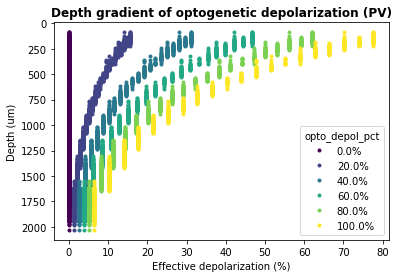

In [337]:
plot_depth_gradient(neuron_info_PV['depth'], opto_strength_eff_PV, opto_depol_pct, save_path, save_spec='PV')

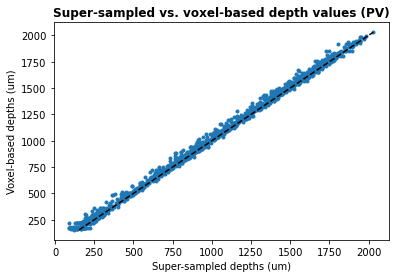

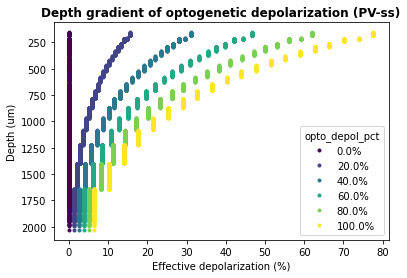

In [340]:
# Compare with voxel-based depth values from '/gpfs/bbp.cscs.ch/project/proj83/home/bolanos/BB_Rat_SSCX_flatmap_v2_depths.nrrd'
# which were used for target definition in the first place

# TODO: Check if opto stim generator needs to be updated using super-sampled depths values???

opto_depth_map_file = psth_data_PV[0]['opto_cfg']['cfg']['opto_depth_map_file']
gids = gids_PV

# Load depth map
import voxcell
depth_map = voxcell.VoxelData.load_nrrd(opto_depth_map_file)

# Get depth values
nrn_pos = circuit.cells.positions(gids)
nrn_depths = depth_map.lookup(np.array(nrn_pos)).astype(float)

# Interpolate missing values (nearest-neighbor interpolation)
from scipy.interpolate import griddata
if np.any(nrn_depths == -1.0):
    map_indices = depth_map.positions_to_indices(nrn_pos, keep_fraction=True) # Keep fractions within voxels => fraction x.5 corresponds to voxel center
    map_pos = np.floor(map_indices) + 0.5 # Voxel values assumed to correspond to voxel center
    nrn_depths = griddata(map_pos[nrn_depths != -1], nrn_depths[nrn_depths != -1], map_indices, method='nearest')
nrn_depths = pd.Series(nrn_depths, index=gids, name='depth')
assert min(nrn_depths) >= 0.0, 'ERROR: Depth values cannot be negative!'

plt.figure()
plt.plot(neuron_info_PV['depth'], nrn_depths, '.')
plt.plot([min(nrn_depths), max(nrn_depths)], [min(nrn_depths), max(nrn_depths)], '--k')
plt.xlabel('Super-sampled depths (um)')
plt.ylabel('Voxel-based depths (um)')
plt.title('Super-sampled vs. voxel-based depth values (PV)', fontweight='bold')
plt.savefig(os.path.join(save_path, f'opto_depth_comparison_PV.png'), dpi=300)
plt.show()

plot_depth_gradient(nrn_depths, opto_strength_eff_PV, opto_depol_pct, save_path, save_spec='PV-ss')

### Quantification of tuning curve fits

In [16]:
# Check/plot goodness-of-fit values ... TODO

# Plot opt fit params
# - Single cells
# - Single cells separated by layer/depth ... TODO
# - Single cells gruped by effective opto strength based on depth and opto pct ... TODO
# - Per-layer mean ... TODO (?)

# Clustering of opt fit params??
# Pre-selection of cells with sigmoidal tuning curve shape in baseline + preserving shape!!
# (i.e., Excluding outliers/special cases, like non-monotonously increasing tuning responses)

# Fit params of mean tuning curves ... TODO (?)
# - Overall
# - Per-layer

# Boxplot of opt fit param distributions for different levels of opto stim

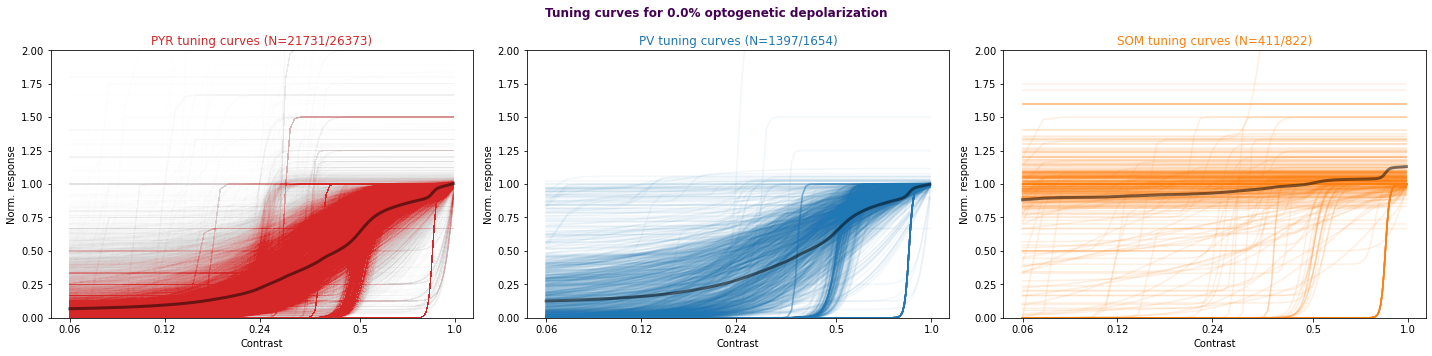

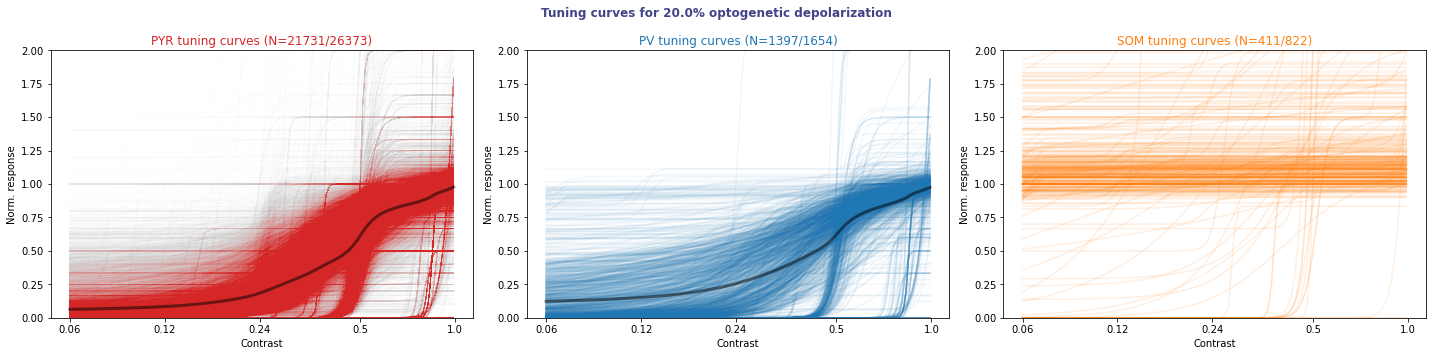

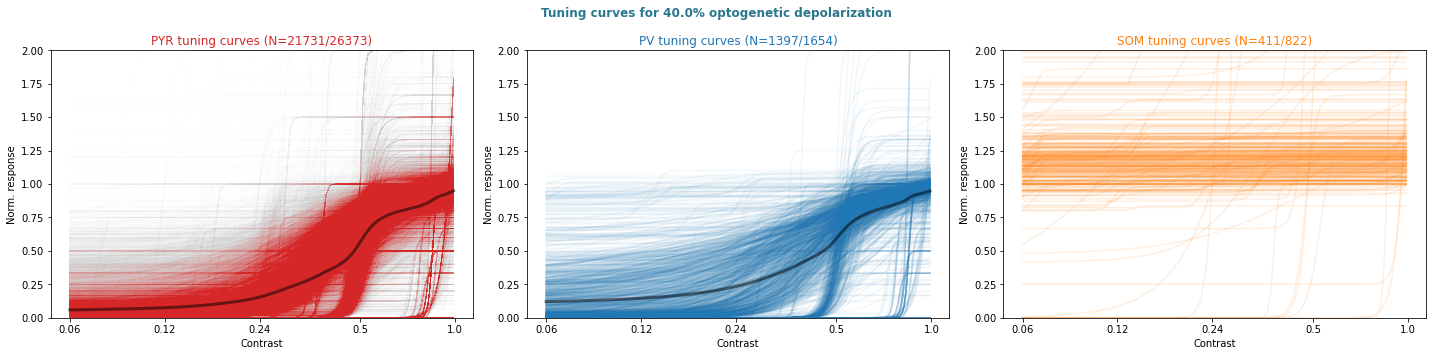

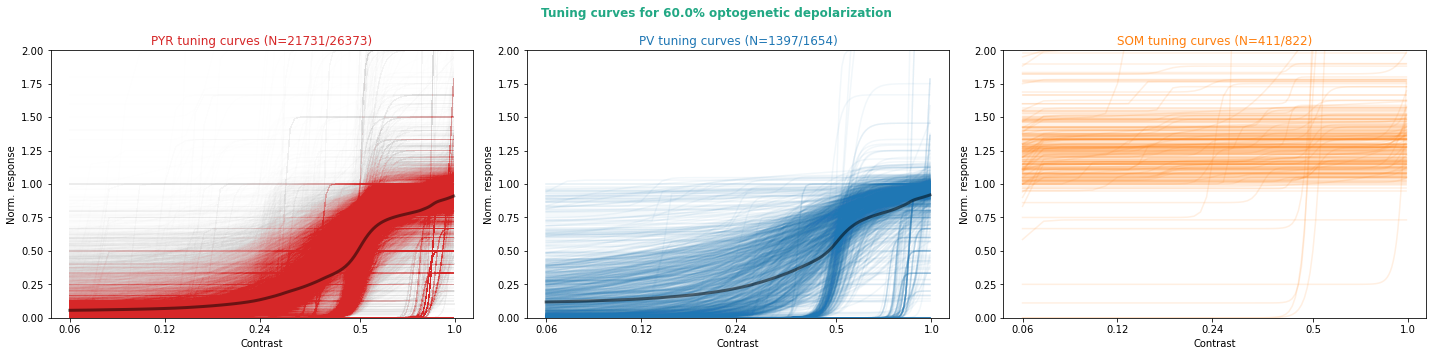

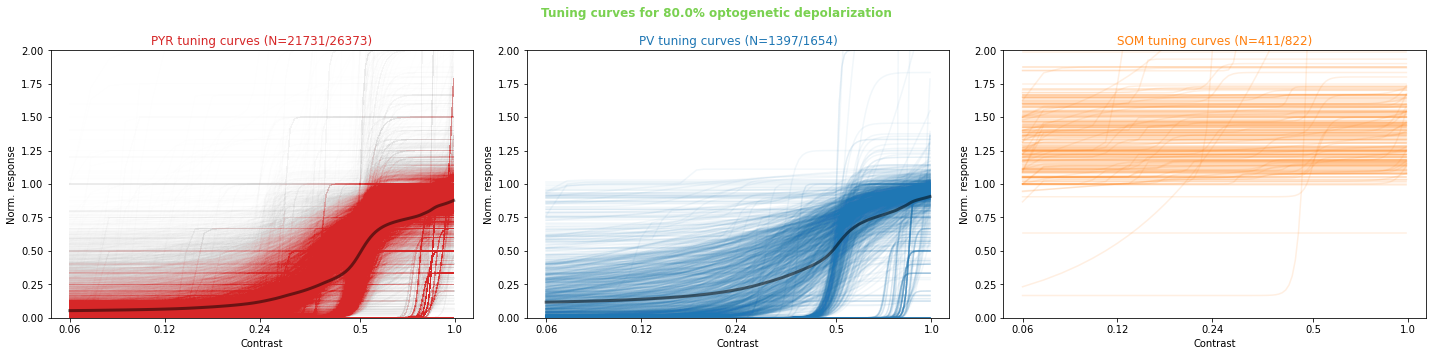

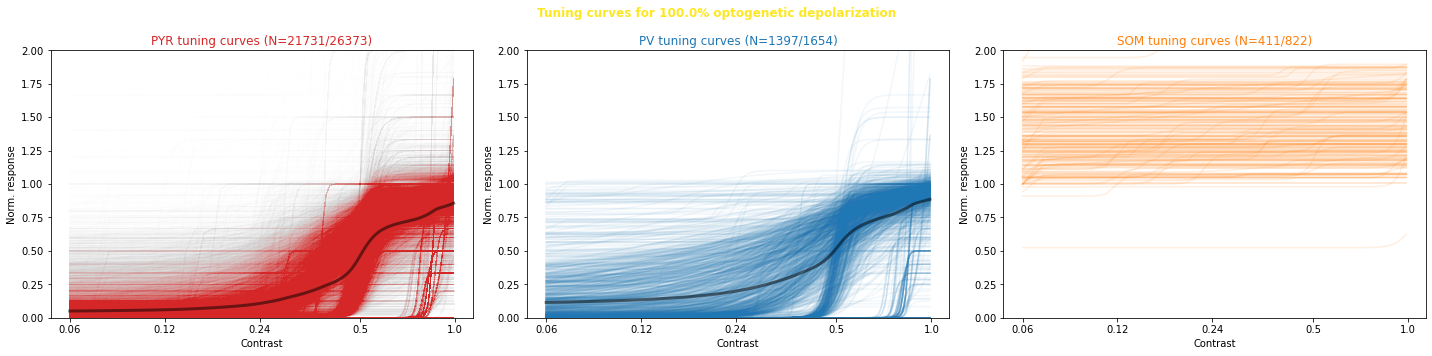

In [19]:
# Plot tuning curves
c = np.arange(min(contrasts), max(contrasts), 0.01)
level_colors = plt.cm.viridis(np.linspace(0, 1, len(opto_depol_pct)))
for opto_idx, pct in enumerate(opto_depol_pct):
    plt.figure(figsize=(20, 5))
    for idx, (opt_fit_params, lbl, col) in enumerate(zip([opt_fit_params_PYR[opto_idx], opt_fit_params_PV[opto_idx], opt_fit_params_SOM[opto_idx]], ['PYR', 'PV', 'SOM'], ['tab:red', 'tab:blue', 'tab:orange'])):
        N = np.sum(np.all(np.isfinite(opt_fit_params), 1))
        plt.subplot(1, 3, idx + 1)
        r = np.array([R(c, *p_opt) for p_opt in opt_fit_params])
        plt.plot(c, r.T, color=col, alpha=100.0 / opt_fit_params.shape[0])
        plt.plot(c, np.nanmean(r, 0), 'k', alpha=0.5, lw=3)
        plt.ylim([0.0, 2.0])
        plt.gca().set_xscale('log')
        plt.xticks(contrasts, labels=contrasts)
        plt.gca().minorticks_off()
        plt.xlabel('Contrast')
        plt.ylabel('Norm. response')
        plt.title(f'{lbl} tuning curves (N={N}/{opt_fit_params.shape[0]})', color=col)
    plt.suptitle(f'Tuning curves for {pct}% optogenetic depolarization', fontweight='bold', color=level_colors[opto_idx])
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f'tuning_curves_{pct}pct.png'), dpi=300)
    plt.show()

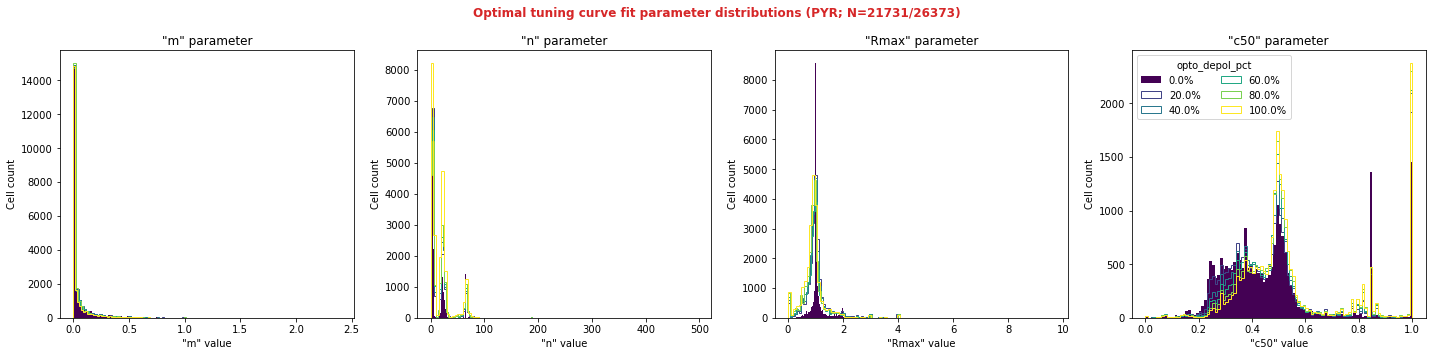

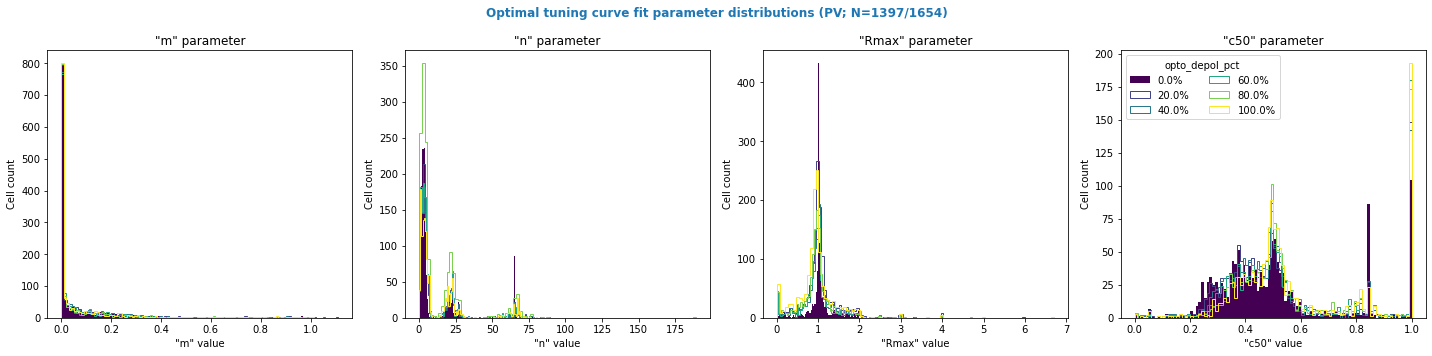

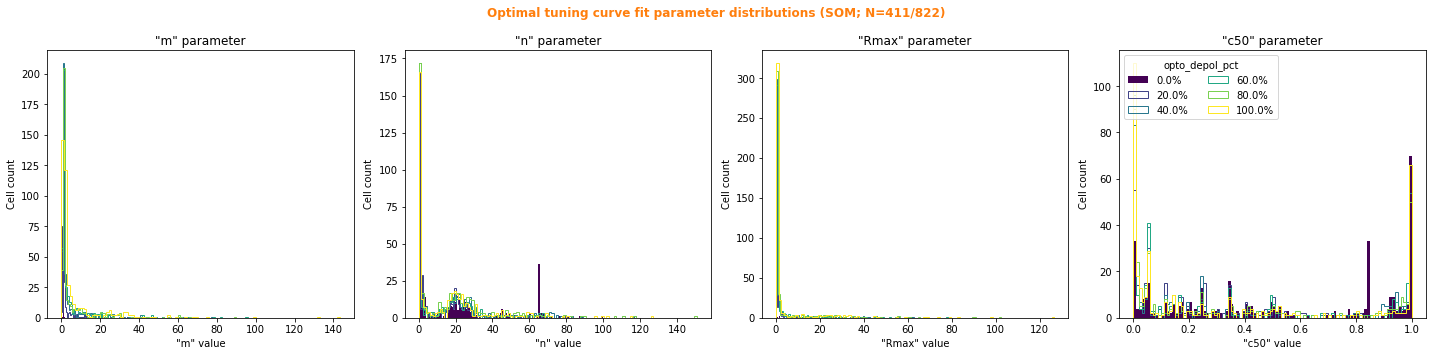

In [20]:
# Plot opt. fitting parameter distributions
num_bins = 100
for opt_fit_params, lbl, col in zip([opt_fit_params_PYR, opt_fit_params_PV, opt_fit_params_SOM], ['PYR', 'PV', 'SOM'], ['tab:red', 'tab:blue', 'tab:orange']):
    N = np.sum(np.all(np.isfinite(opt_fit_params[0]), 1))
    plt.figure(figsize=(20, 5))
    for idx, p_name in enumerate(fit_param_names):
        plt.subplot(1, num_fit_params, idx + 1)
        for opto_idx, pct in enumerate(opto_depol_pct):
            plt.hist(opt_fit_params[opto_idx][:, idx], bins=num_bins, color=level_colors[opto_idx], histtype='bar' if opto_idx == 0 else 'step', label=f'{pct}%')
        plt.xlabel(f'"{p_name}" value')
        plt.ylabel('Cell count')
        plt.title(f'"{p_name}" parameter')
        # plt.yscale('log')
    plt.legend(title='opto_depol_pct', ncol=2, loc='upper left')
    plt.suptitle(f'Optimal tuning curve fit parameter distributions ({lbl}; N={N}/{opt_fit_params[0].shape[0]})', fontweight='bold', color=col)
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f'fit_param_histograms_{lbl}.png'), dpi=300)
    plt.show()

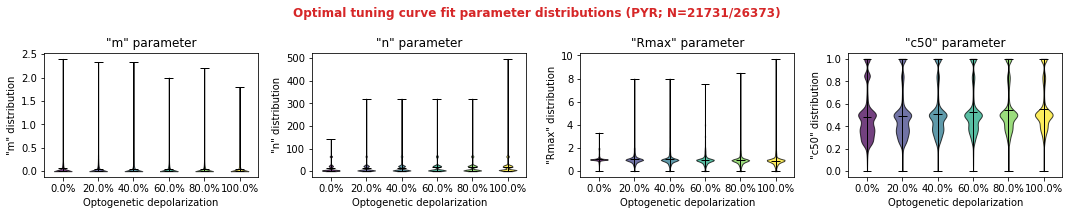

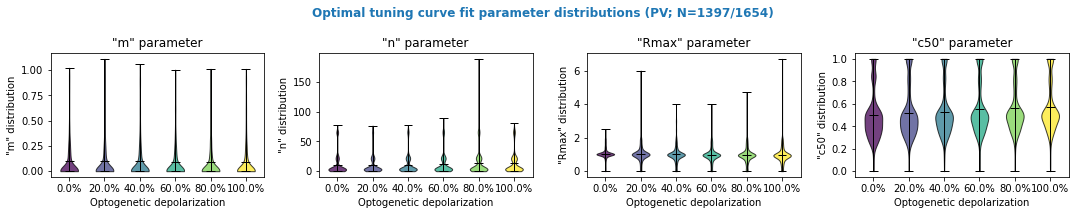

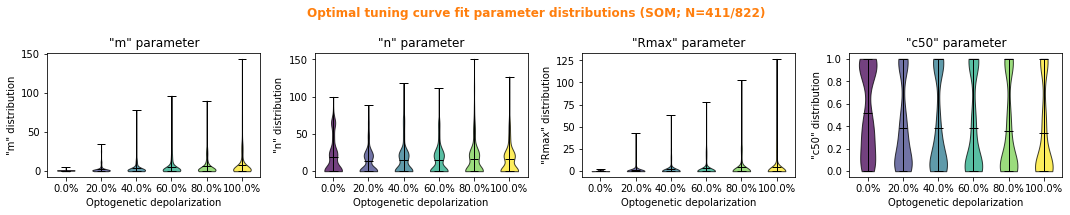

In [21]:
# Plot violinplots of opt fit param distributions for different levels of opto stim
for opt_fit_params, lbl, col in zip([opt_fit_params_PYR, opt_fit_params_PV, opt_fit_params_SOM], ['PYR', 'PV', 'SOM'], ['tab:red', 'tab:blue', 'tab:orange']):
    N = np.sum(np.all(np.isfinite(opt_fit_params[0]), 1))
    plt.figure(figsize=(15, 3))
    for p_idx, p_name in enumerate(fit_param_names):
        plt.subplot(1, len(fit_param_names), p_idx + 1)
        p_data = [opt_fit_params[idx][np.all(np.isfinite(opt_fit_params[idx]), 1), p_idx] for idx in range(len(opto_depol_pct))]
        violin_parts = plt.violinplot(p_data, showmeans=True)
        for partname in ('cbars','cmins','cmaxes','cmeans', 'cmedians'):
            if partname in violin_parts:
                violin_parts[partname].set_edgecolor('k')
                violin_parts[partname].set_linewidth(1)
        for idx, pc in enumerate(violin_parts['bodies']):
            pc.set_facecolor(level_colors[idx])
            pc.set_alpha(0.75)
            pc.set_edgecolor('black')
        plt.xticks(np.arange(1, len(opto_depol_pct) + 1), labels=[f'{pct}%' for pct in opto_depol_pct])
        plt.xlabel('Optogenetic depolarization')
        plt.ylabel(f'"{p_name}" distribution')
        plt.title(f'"{p_name}" parameter')
    plt.suptitle(f'Optimal tuning curve fit parameter distributions ({lbl}; N={N}/{opt_fit_params[0].shape[0]})', fontweight='bold', color=col)
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f'fit_param_violins_{lbl}.png'), dpi=300)
    plt.show()

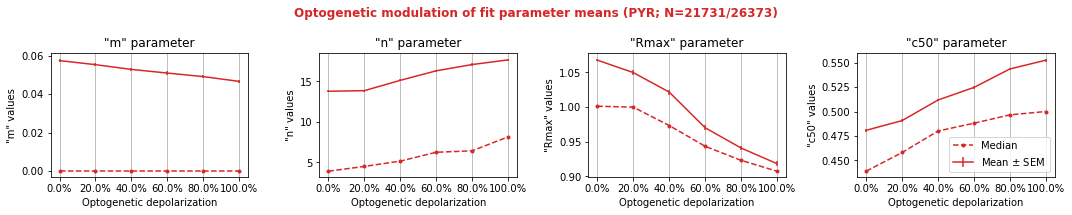

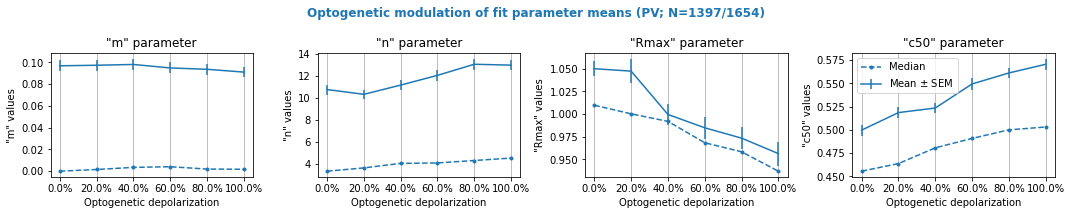

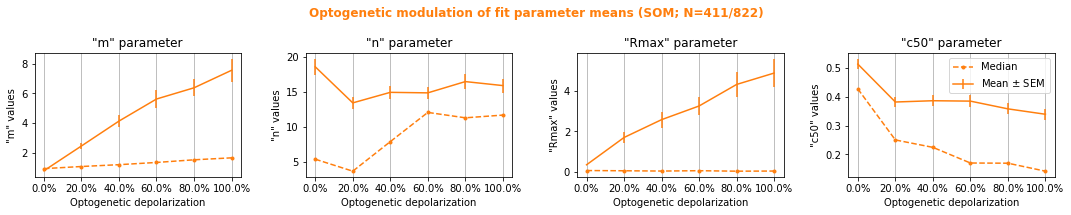

In [22]:
# Plot means of opt fit param distributions for different levels of opto stim
c = np.arange(min(contrasts), max(contrasts), 0.01)

for opt_fit_params, lbl, col in zip([opt_fit_params_PYR, opt_fit_params_PV, opt_fit_params_SOM], ['PYR', 'PV', 'SOM'], ['tab:red', 'tab:blue', 'tab:orange']):
    N = np.sum(np.all(np.isfinite(opt_fit_params[0]), 1))
    plt.figure(figsize=(15, 3))
    for p_idx, p_name in enumerate(fit_param_names):
        plt.subplot(1, len(fit_param_names), p_idx + 1)
        mean_data = [np.nanmean(opt_fit_params[idx][:, p_idx]) for idx in range(len(opto_depol_pct))]
        median_data = [np.nanmedian(opt_fit_params[idx][:, p_idx]) for idx in range(len(opto_depol_pct))]
        std_data = [np.nanstd(opt_fit_params[idx][:, p_idx]) / np.sqrt(N) for idx in range(len(opto_depol_pct))]
        plt.errorbar(np.arange(0, len(opto_depol_pct)), mean_data, yerr=std_data, color=col, label='Mean $\pm$ SEM')
        plt.plot(np.arange(0, len(opto_depol_pct)), median_data, '.--', color=col, label='Median')
        plt.xticks(np.arange(0, len(opto_depol_pct)), labels=[f'{pct}%' for pct in opto_depol_pct])
        plt.xlabel('Optogenetic depolarization')
        plt.ylabel(f'"{p_name}" values')
        plt.title(f'"{p_name}" parameter')
        plt.grid(axis='x')
    plt.legend()
    plt.suptitle(f'Optogenetic modulation of fit parameter means ({lbl}; N={N}/{opt_fit_params[0].shape[0]})', fontweight='bold', color=col)
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f'fit_param_means_{lbl}.png'), dpi=300)
    plt.show()

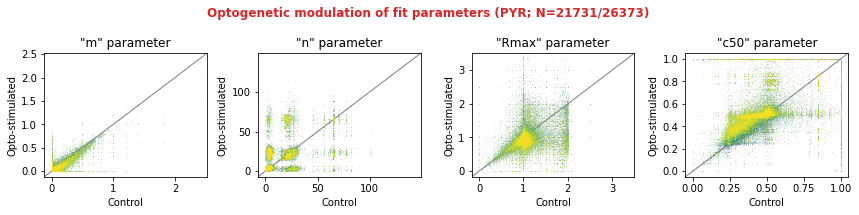

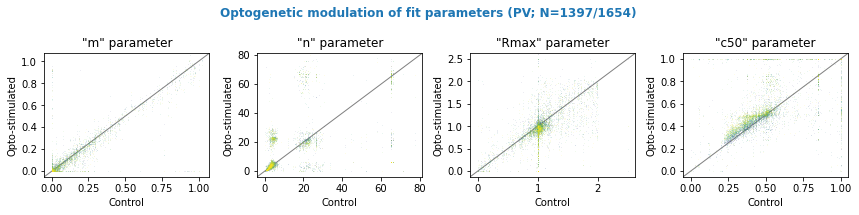

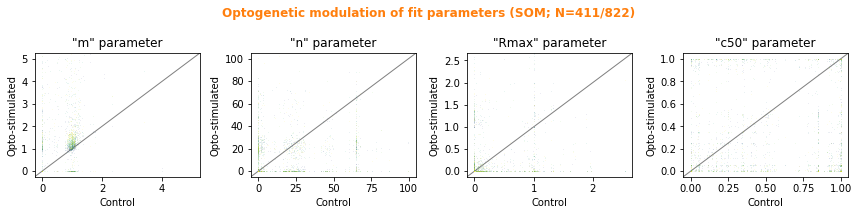

In [23]:
# Plot scatter plots of fitting parameters (Control vs. Opto)
ctrl_idx = np.where(np.array(opto_depol_pct) == 0.0)[0][0]
opto_idx = np.where(np.array(opto_depol_pct) > 0.0)[0]
# opto_idx = [np.where(np.array(opto_depol_pct) > 0.0)[0][0]]

for opt_fit_params, lbl, col in zip([opt_fit_params_PYR, opt_fit_params_PV, opt_fit_params_SOM], ['PYR', 'PV', 'SOM'], ['tab:red', 'tab:blue', 'tab:orange']):
    N = np.sum(np.all(np.isfinite(opt_fit_params[0]), 1))
    plt.figure(figsize=(12, 3))
    for p_idx, p_name in enumerate(fit_param_names):
        plt.subplot(1, len(fit_param_names), p_idx + 1)
        for o_idx in opto_idx:
            plt.plot(opt_fit_params[ctrl_idx][:, p_idx], opt_fit_params[o_idx][:, p_idx], '.', markersize=1, markeredgecolor='none', color=level_colors[o_idx], alpha=0.5, label=f'{opto_depol_pct[o_idx]}%')
        plt.xlim(plt.xlim())
        plt.ylim(plt.xlim())
#         plt.ylim(plt.ylim())
        ax_min = np.minimum(plt.xlim()[0], plt.ylim()[0])
        ax_max = np.maximum(plt.xlim()[1], plt.ylim()[1])
        plt.plot([ax_min, ax_max], [ax_min, ax_max], '-', lw=1, color='grey', zorder=0)
        plt.xlabel('Control')
        plt.ylabel('Opto-stimulated')
        plt.title(f'"{p_name}" parameter')
#         plt.legend()
    plt.suptitle(f'Optogenetic modulation of fit parameters ({lbl}; N={N}/{opt_fit_params[0].shape[0]})', fontweight='bold', color=col)
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f'fit_param_scatters_{lbl}.png'), dpi=300)
    plt.show()

In [273]:
# # Plot medians of opt fit param distributions for different levels of opto stim
# c = np.arange(min(contrasts), max(contrasts), 0.01)

# for opt_fit_params, lbl, col in zip([opt_fit_params_PYR, opt_fit_params_PV, opt_fit_params_SOM], ['PYR', 'PV', 'SOM'], ['tab:red', 'tab:blue', 'tab:orange']):
#     N = np.sum(np.all(np.isfinite(opt_fit_params[0]), 1))
#     plt.figure(figsize=(20, 3))
#     for p_idx, p_name in enumerate(fit_param_names):
#         plt.subplot(1, len(fit_param_names) + 1, p_idx + 1)
#         median_data = [np.nanmedian(opt_fit_params[idx][:, p_idx]) for idx in range(len(opto_depol_pct))]
#         plt.plot(np.arange(0, len(opto_depol_pct)), median_data, color=col)
#         for opto_idx in range(len(opto_depol_pct)):
#             plt.plot(opto_idx, median_data[opto_idx], 'o', color=level_colors[opto_idx], zorder=0)
#         plt.xticks(np.arange(0, len(opto_depol_pct)), labels=[f'{pct}%' for pct in opto_depol_pct])
#         plt.xlabel('Optogenetic depolarization')
#         plt.ylabel(f'"{p_name}" Mean $\pm$ SEM')
#         plt.title(f'"{p_name}" parameter')
#         plt.grid(axis='x')
#     plt.subplot(1, len(fit_param_names) + 1, len(fit_param_names) + 1)
#     for opto_idx in range(len(opto_depol_pct)):
#         p_mean = np.nanmean(opt_fit_params[opto_idx], 0)
#         plt.plot(c, R(c, *p_mean), color=level_colors[opto_idx])
#     plt.gca().set_xscale('log')
#     plt.xticks(contrasts, labels=contrasts)
#     plt.gca().minorticks_off()
#     plt.xlabel('Contrast')
#     plt.ylabel('Norm. response')
#     plt.title(f'Tuning curves of mean param sets')
#     plt.suptitle(f'Opto modulation of fit parameter medians ({lbl}; N={N}/{opt_fit_params[0].shape[0]})', fontweight='bold', color=col)
#     plt.tight_layout()
#     plt.savefig(f'fit_param_medians_{lbl}.png', dpi=300)
#     plt.show()